### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

### Preprocessing Data For Modeling

In [3]:
##define input
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_feature_file = 'data/test_features.csv'

# Define variables
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numerical_vars = ['yearsExperience', 'milesFromMetropolis']
target_vars = 'salary'
connecting_column = 'jobId'


# load data
print("Loading Data")
feature_df = load_dataset(train_feature_file)
target_df = load_dataset(train_target_file)
test_df = load_dataset(test_feature_file)

# Merge the training data
raw_train_df = consolidate_data(feature_df, target_df, key = connecting_column)

# Clean, rearange and reindex training data as rearranging improves cross-validation accuracy
clean_train_df = clean_data(raw_train_df, connecting_column, target_vars, rearrange=True)

# Encoding categorical data and get final feature dataframes
print("Encoding Data")
feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars=categorical_vars, num_vars=numerical_vars)
test_df = one_hot_encode_feature_df(test_df,cat_vars=categorical_vars, num_vars=numerical_vars)

# get target df
print("Obtaining the target variable")
target_df = get_target_df(clean_train_df, target_vars)

Loading Data
Encoding Data
Obtaining the target variable


## 5. Modeling

In [6]:
#initialize model list and dicts
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parrallel
num_procs = 2

#shared model parameters
verbose_level = 0

## Create Model

In [9]:
# BaseLine models 
lr = LinearRegression()
#parallel cross-validate models, using MSE as evaluation metric and print summaries 
print("Beginning cross validation")
train_model(lr, feature_df, target_df, num_procs, mean_mse, cv_std)
print_summary(lr, mean_mse, cv_std)

Beginning cross validation

Model: 
 LinearRegression()

Average MSE: 
 384.47326160447574

Standard deviation during CV: 
 0.757066905676453


In [11]:
# Another BaseLine models 
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
#parallel cross-validate models, using MSE as evaluation metric and print summaries 
print("Beginning cross validation")
train_model(lr_std_pca, feature_df, target_df, num_procs, mean_mse, cv_std)
print_summary(lr_std_pca, mean_mse, cv_std)

Beginning cross validation

Model: 
 Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])

Average MSE: 
 384.50053951807934

Standard deviation during CV: 
 0.739516095374853


In [12]:

gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=verbose_level)
#parallel cross-validate models, using MSE as evaluation metric and print summaries 
print("Beginning cross validation")
train_model(gbm, feature_df, target_df, num_procs, mean_mse, cv_std)
print_summary(gbm, mean_mse, cv_std)

Beginning cross validation

Model: 
 GradientBoostingRegressor(max_depth=5, n_estimators=150)

Average MSE: 
 357.1717355417369

Standard deviation during CV: 
 0.6867436860884766


### Different estimators with Hyperparameter tuning by hand 

In [18]:
# choose model with lowest mse
model = min(mean_mse, key =mean_mse.get)
print('\nPredictions calculated using model with lowest MSE')
print(model)

# Train the model on the entire dataset
model.fit(feature_df, target_df)

# create predictions based on test data
predictions = model.predict(test_df)


Predictions calculated using model with lowest MSE
GradientBoostingRegressor(max_depth=5, n_estimators=150)


In [34]:
#store feature importance
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature importance
    importances = [0] * len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature': feature_df.columns, 'importance': importances})
feature_importances.sort_values(by = 'importance', ascending = False, inplace = True)
# Set index to 'feature'
feature_importances.set_index('feature', inplace = True, drop = True)

# save results
save_results(model, mean_mse[model], predictions, feature_importances)

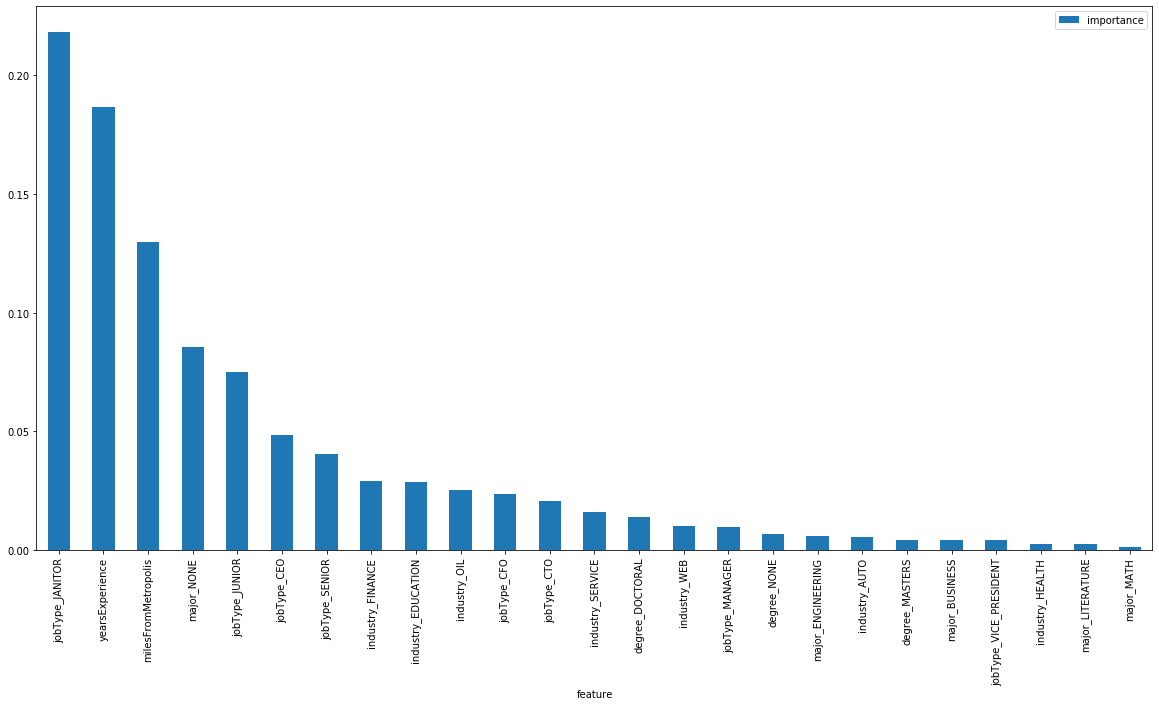

In [39]:
# Visualize the feature importance
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

In [35]:
!cat model.txt

GradientBoostingRegressor(max_depth=5, n_estimators=150)

In [37]:
!head feature_importances

feature,importance
jobType_JANITOR,0.21828490267922956
yearsExperience,0.18671955106863095
milesFromMetropolis,0.12977153159094487
major_NONE,0.08562541642547006
jobType_JUNIOR,0.07476353234820471
jobType_CEO,0.04849366045788037
jobType_SENIOR,0.04021898714705644
industry_FINANCE,0.02897898740675118
industry_EDUCATION,0.02856866027980081


In [38]:
!head predictions.csv

1.112319470299436972e+02
9.358076805149416089e+01
1.789313055117162321e+02
1.043686516871985788e+02
1.170745237113825823e+02
1.507164339871127652e+02
9.642931186092559415e+01
1.185500271711056826e+02
1.069490341265068594e+02
9.826842079587653700e+01


### Helper Function

In [40]:
# load the data
def load_dataset(file):
    """
    Read a comma-separated values (csv) file into DataFrame.
    
    Parameters
    ----------
    file: the directory of the dataset
    """
    return pd.read_csv(file)

#Merge Dataset
def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    """
    Performs inner join to return only records that are present in both dataframe
    
    Parameters
    ----------
    
    df1: DataFrame1
    df2: DataFrame2
    key: Column or index level names to join on. These must be found in both DataFrames.
    
    left_index: bool, default False
                Use the index from the left DataFrame as the join key(s). If it is a
                MultiIndex, the number of keys in the other DataFrame (either the index
                or a number of columns) must match the number of levels.
    
    right_index: bool, default False
                 Use the index from the right DataFrame as the join key. Same caveats as left_index.
    
    """
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)
    

# Check for duplicates
def check_for_duplicates(*dataframes):
    """
    Return the number of duplicates in a dataframe
    
    Parameters
    ----------
    dataframes: Name of the dataframes
    
    """
    for dataframe in dataframes:
        name =[x for x in globals() if globals()[x] is dataframe][0]
        print(f' Duplicates in {name} = {dataframe.duplicated().sum()}')
        

# Visualize a single column of a DataFrame
def visualize_column(data, bins=10):
    """
    Returns a boxplot and displot of a single columns from a dataset
    
    Parameters
    ----------
    data : DataFrame, array, or list of arrays Dataset for plotting. 
    
    bins : argument for matplotlib hist(), or Default is 10, optional
           Specification of hist bins, or None to use Freedman-Diaconis rule.
    
    """
    plt.figure(figsize = (14,6))
    plt.subplot(1,2,1)
    sns.boxplot(data)
    plt.subplot(1,2,2)
    sns.distplot(data, bins)
    plt.show()

# Statistical Reports of a given data
def statistical_reports(data):
    """
    Generate descriptive statistics that summarize the central tendency,
    dispersion and shape of a dataset's distribution, excluding ``NaN`` values
    
    Analyzes both numeric and object series, as well as ``DataFrame`` 
    column sets of mixed data types. The output will vary depending on what is provided
    
    Also provides the potential outliers (lower bounds and upper bounds).
    
    Parameters
    ----------
    data : DataFrame, array, or list of arrays Dataset
    
    """
    stat = data.describe()
    print(stat)
    IQR = stat['75%'] - stat['25%']
    upper = stat['75%'] + 1.5*IQR
    lower = stat['25%'] - 1.5*IQR
    print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

# Clean Data
def clean_data(raw_df, duplicate_column_check, target_column, rearrange = False):
    """
    Remove rows that contain value of target_column (salary in this case) < 0 
    and check duplicate based on a single column
    
    Parameters
    ----------
    
    raw_df: Dataset that are targeted to be cleaned
    duplicate_column_check: name the column on the raw_df that may have duplicates
    target_column: predicted column
    rearrange: Default False. 
               Shuffle and reindex data -- shuffling improves cross-validation
    """
    clean_df = raw_df.drop_duplicates(subset= duplicate_column_check)
    clean_df = clean_df[clean_df[target_column]>0]
    if rearrange == False:
        return clean_df
    else:
        return shuffle(clean_df).reset_index()
    
# Plot Feature
def plot_feature(df, col):
    """
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    
    Parameters
    ----------
    df : DataFrame, array, or list of arrays Dataset
    col: columns of a dataframe
    
    """
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    
    plt.subplot(1, 2, 2)
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')

# encode label
def encode_label(df, col):
    '''
    encode the categories using average salary for each category to replace label
    
    Parameters
    ----------
    df: Name of the dataframes
    col: column in the dataframe
    '''
    
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = train_df[train_df[col]==cat]['salary'].mean()
    df[col] = df[col].map(cat_dict)

# Encoding categorical data and get final feature dataframes
def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    """
    Perfoms one-hot encoding on all categrorical variables and combines result with continuous variable
    Parameters
    ----------
    df: Select the Dataframe
    cat_vars: categorical variables
    num_vars: numerical variables
    """
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#ignore_index = False 

# Get the target variable
def get_target_df(df, target_variable):
    """
    returns the target dataframe
    Parameters
    ----------
    df: dataframe
    target_variable: name the target variable
    
    """
    return df[target_variable]


# train an model
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    """
    Train the sklearn-estimatator
    Parameters
    ----------
    model: estimator object implementing 'fit'
                The object to use to fit the data.

    feature_df : array-like of shape (n_samples, n_features)
                 The data to fit. Can be for example a list, or an array.

    target_df : The target variable to try to predict in the case of supervised learning.
    
    num_procs : int. The number of CPUs to use to do the computation.
    
    mean_mse:
    
    cv_std:
    """
    neg_mse = cross_val_score(model, feature_df, target_df, cv = 2, n_jobs = num_procs, 
                              scoring = 'neg_mean_squared_error')
    mean_mse[model] = (-1)* np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
# Print summary
def print_summary(model, mean_mse, cv_std):
    """
    Print Summary of each model
    Parameters
    ----------
    model: name of the estimators
    mean_mse: Average of the mean squared error
    cv_std: Standard deviation during cross-validation
    """
    print(f'\nModel: \n {model}')
    print(f'\nAverage MSE: \n {mean_mse[model]}')
    print(f'\nStandard deviation during CV: \n {cv_std[model]}')
    
# save results
def save_results(model, mean_mse, predictionn, feature_importances):
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances')
    np.savetxt('predictions.csv', predictions, delimiter=',')